# Neighborhood sizes in 2D and 3D

In [1]:
## Imports
import squidpy as sq
import anndata as ad ## using anndata until sq is spatialdata-compatible
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter1d

In [2]:
## Load 3D data
centroids_3D = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_3D.csv')
adata3 = ad.AnnData(obs=np.empty(centroids_3D.shape[0]), ## placeholder
                    obsm={'spatial': centroids_3D[['x', 'y', 'z']].values})
adata3

AnnData object with n_obs × n_vars = 108486 × 0
    obs: 0
    obsm: 'spatial'

In [3]:
## Choose 2D files for comparison
# We want an approx. equivalent number of cells in 2D and 3D
# such that variability in 2D is not due to fewer cells
fn_2D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"

files_2D = np.array(glob.glob(fn_2D)) ## list of files (full path)

## Get mean n_cells in 2D
n_cells_2D = np.empty(len(files_2D), dtype=int)
for i, file in enumerate(files_2D):
    with open(file) as f:
        n_cells_2D[i] = sum(1 for line in f)-1 ## without header
n_slices = int(np.round(centroids_3D.shape[0] / n_cells_2D.mean()))

## Choose files at random
rng = np.random.default_rng(42) 
rand = rng.choice(len(files_2D), size=n_slices, replace=False)
files_2D_selection = files_2D[rand]
print(f"Selected {n_slices} files")
print(f"n_cells 2D: {n_cells_2D[rand].sum()}; 3D: {centroids_3D.shape[0]}")

Selected 43 files
n_cells 2D: 107374; 3D: 108486


In [4]:
## Load 2D data
centroids_2D = pd.concat([pd.read_csv(file) for file in files_2D_selection])
## To AnnData
## Squidpy currently requires one AnnData object per image
adata2 = [ ad.AnnData(obs = np.empty((centroids_2D['z'] == i).sum()),
                      obsm = {'spatial': centroids_2D.loc[ centroids_2D['z'] == i, ['x', 'y']].values})
                      for i in np.unique(centroids_2D['z']) ]
len(adata2)

43

2D mode: 6.5 μm
3D mode: 6.30 μm


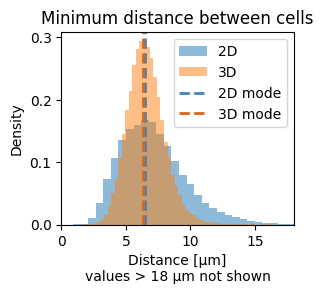

In [9]:
## Min dist between cells
def min_dist_cells(adata):
    tree = cKDTree(adata.obsm['spatial'])
    dists = tree.query(adata.obsm['spatial'], k=2)[0][:,1]
    return dists
dists_2D = [ min_dist_cells(adata) for adata in adata2 ]
dists_3D = min_dist_cells(adata3)
dists_2D = np.concatenate(dists_2D)

# Find mode (more useful than mean due to long tail)
# since continuous, smooth first
def get_mode(dists, maxval):
    bins = np.linspace(0, maxval, maxval*10+1) # step size 0.1
    counts, _ = np.histogram(dists, bins=bins)
    counts_smoothed = gaussian_filter1d(counts, 2)
    mode = bins[ counts_smoothed.argmax() ]
    return mode
maxval = int( np.ceil( np.max([dists_2D.max(), dists_3D.max()]) ) )
mode_2D = get_mode(dists_2D, maxval)
mode_3D = get_mode(dists_3D, maxval)

# Plot
print(f"2D mode: {mode_2D} μm\n3D mode: {mode_3D:.2f} μm")
plt.subplots(figsize=(3,2.5))
plt.hist(dists_2D, bins=100, alpha=0.5, density=True, label='2D')
plt.hist(dists_3D, bins=100, alpha=0.5, density=True, label='3D')
plt.axvline(mode_2D, color='steelblue', linestyle='dashed', linewidth=2, label='2D mode')
plt.axvline(mode_3D, color='chocolate', linestyle='dashed', linewidth=2, label='3D mode')
plt.xlim(0, 18)
plt.title('Minimum distance between cells')
plt.xlabel('Distance [μm]\nvalues > 18 μm not shown')
plt.ylabel('Density')
plt.legend()
plt.savefig('../../figures/minimum_distance_between_cells.svg', bbox_inches='tight')
plt.show()

In [28]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dists_2D, dists_3D, alternative='greater')
print(f"p-value: {p:.2e}")

p-value: 0.00e+00


In [11]:
## Get number of neighbors for a range of radii
def get_knns(adata, radius):
    ## Build spatial graph
    connectivities, _ = sq.gr.spatial_neighbors(adata, spatial_key="spatial", coord_type='generic',
                                                delaunay=False, radius=radius, copy=True)
    ## Get number of neighbors per cell
    nneighbors = np.array(connectivities.sum(1)).squeeze()
    return nneighbors

radii = np.arange(10, 51, 10)
knns = pd.DataFrame(columns=['radius','mean_2','sdev_2', 'mean_3', 'sdev_3'])
knns['radius'] = radii
for radius in radii:
    radius = int(radius) ## type conversion for squidpy function
    ## in 2D
    nn2 = get_knns(adata2[0], radius)
    for adata in adata2[1:]:
        nn2 = np.append(nn2, get_knns(adata, radius))
    knns.loc[knns['radius'] == radius, ['mean_2', 'sdev_2']] = [nn2.mean(), nn2.std()]
    ## in 3D
    nn3 = get_knns(adata3, radius)
    knns.loc[knns['radius'] == radius, ['mean_3', 'sdev_3']] = [nn3.mean(), nn3.std()]
knns

,radius,mean_2,sdev_2,mean_3,sdev_3
0,10,1.94671,1.246079,4.428498,2.086939
1,20,9.858066,3.180636,38.229357,11.110664
2,30,22.289325,6.293464,124.958704,35.061542
3,40,39.134818,10.546328,286.74216,82.085327
4,50,60.213851,16.028763,542.962631,160.204455


In [17]:
## Sanity check
radius = 10
connectivities, distances = sq.gr.spatial_neighbors(adata3, spatial_key="spatial", coord_type='generic',
                                                    delaunay=False, radius=radius, copy=True)
assert distances.max() <= radius ## no distance > radius
pt0 = adata3.obsm['spatial'][0]
pt1 = adata3.obsm['spatial'][distances.indices[0]] ## a neighbor of pt0
assert distances.data[0] == np.sqrt(((pt0 - pt1)**2).sum()) ## distance calc. by squidpy == calc. by hand

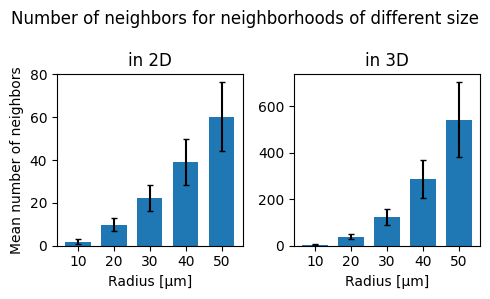

In [35]:
## Plot
## Different plots per dimensionality to read values for 2D better
fig, ax = plt.subplots(1, 2, figsize=(5, 3))
plt.suptitle('Number of neighbors for neighborhoods of different size')
for i in [2, 3]:
        ax[i-2].bar(knns['radius'], knns[f'mean_{i}'], yerr=knns[f'sdev_{i}'], width=7, capsize=2)
        ax[i-2].set_xticks(knns['radius'])
        ax[i-2].set_title(f'in {i}D')
        ax[i-2].set_xlabel('Radius [μm]')
ax[0].set_ylabel('Mean number of neighbors')
fig.tight_layout()
plt.savefig('../../figures/knn_2D_3D_barplot.svg', bbox_inches='tight')
plt.show()

Let's check whether the number of neighbors makes sense geometrically. For simplicity, we use the assumption that the cells are approximately equally distributed in space, such that the number of cells in an area/volume can be used as a unit of area/volume itself. We then expect the following relationship:
- area of a circle: $A = π r^2$
- volume of a sphere: $V = 4/3 π r^3$
- expected relationship: $A / V = knn_{2D} / knn_{3D} = 3/(4r)$

R=1.0


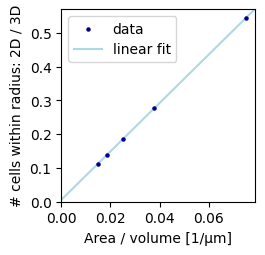

In [36]:
from scipy.stats import linregress
x = np.array( 3 / ( 4 * knns['radius'] ) ).astype(float)
y = np.array( (knns['mean_2']+1) / (knns['mean_3']+1) ).astype(float) # +1 to add index cell
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f'R={r_value:.2}')

plt.subplots(figsize=(2.5,2.5))
plt.scatter(x, y, label='data', s=5, zorder=2.5, color='darkblue')
plt.axline((0, intercept), slope=slope, label=f'linear fit', color='lightblue')
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Area / volume [1/μm]')
plt.ylabel('# cells within radius: 2D / 3D')
plt.legend(loc='upper left')
plt.savefig('../../figures/knn_2D_3D_geom.svg')
plt.show() 

In [21]:
## Create a table to translate knn from 2D to 3D
## Interpolate from calculated values
outfile = '../../data/Kuett_2022/MainHer2BreastCancerModel/knn_2D_to_3D.csv'

knns2D = np.arange(3,51)
knns3D = np.interp(knns2D, knns['mean_2'].astype(float), knns['mean_3'].astype(float))
knns_interp = pd.DataFrame({'knn_2D': knns2D, 'knn_3D': np.round(knns3D).astype(int)})
knns_interp.to_csv(outfile, sep=",", index=False)
knns_interp.head()

,knn_2D,knn_3D
0,3,9
1,4,13
2,5,17
3,6,22
4,7,26


In [5]:
## Load data if previously saved
knns_interp = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/knn_2D_to_3D.csv')

In [22]:
## Number of neighbors using Delaunay triangulation
def get_knns_delaunay(adata):
    connectivities, _ = sq.gr.spatial_neighbors(adata, spatial_key="spatial", coord_type='generic',
                                                delaunay=True, copy=True)
    nneighbors = np.array(connectivities.sum(1)).squeeze()
    return nneighbors
## in 2D
nn2 = get_knns_delaunay(adata2[0])
for adata in adata2[1:]:
    nn2 = np.append(nn2, get_knns_delaunay(adata))
## in 3D
nn3 = get_knns_delaunay(adata3)

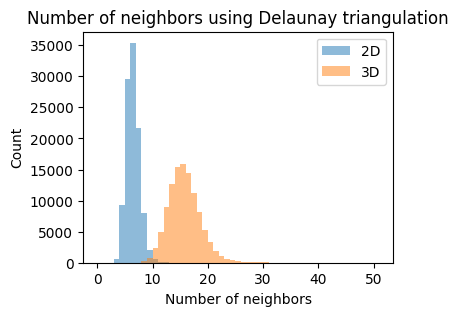

In [23]:
## Plot
plt.subplots(figsize=(4,3))
bins = np.arange(0, max(nn2.max(), nn3.max())+1, 1)
plt.hist(nn2, bins=bins, alpha=0.5, label='2D')
plt.hist(nn3, bins=bins, alpha=0.5, label='3D')
plt.title('Number of neighbors using Delaunay triangulation')
plt.xlabel('Number of neighbors')
plt.ylabel('Count')
plt.legend()
plt.show()